# Automatic Differentiation

For neural nets, any layer with $m$ inputs and $n$ weights can be written as 

$$\mathbf{Z} = f_{\Theta^1, \ldots, \Theta^n}(\mathbf{Z}_{\text{in}}^1, \ldots, \mathbf{Z}_{\text{in}}^m).$$

Hence, for each layer / OP it sufficies to *specify* (1) **input gradients** ${\partial \mathbf{Z}}/{\partial{\mathbf{Z}_{\text{in}}^i}}$ for $i = 1, \ldots, m$ and (2) **weight gradients** ${\partial \mathbf{Z}}/{\partial{\Theta}^k}$ for $k= 1, \ldots, n.$ So that these gradients can be **accessed** by any node  ${\mathbf{Z}}$ that $\mathbf{U}$ is a parent of. Thus,

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{U}} 
=
\sum_{{\mathbf{Z}} \in C(\mathbf{U})} \pi\left(
    \frac{\partial \mathcal{L}}{\partial {{\mathbf{Z}}}},  
    \frac{\partial {\mathbf{Z}}}{\partial {\mathbf{U}}}
\right)
$$

where $C(\mathbf{U}) = \{ \mathbf{Z} \mid \exists i, k \; \text{s.t.}\; (\mathbf{U} = {\mathbf{Z}}_\text{in}^i) \vee (\mathbf{U} = {\Theta}^k) \}$ are the child nodes of $\mathbf{U}$ and $\pi$ is an operator that abstracts the actual product (i.e. summing over an index) between the two tensors. That's easy enough for static graphs, but if we want to dynamically build the computational graph for arbitrary programs, then we have to do some abstraction. 

For example, consider the binary OP $\mathbf{Z} = \phi(\mathbf{U}_1, \mathbf{U}_2).$ Then, we have to determine $\xi_1$ and $\xi_2$ where:

$$
\begin{aligned}
\xi_1(\mathbf{G}) &= \pi \left(\mathbf{G}, \frac{\partial \phi(\mathbf{U}_1, \mathbf{U}_2)}{\partial\mathbf{U}_1} \right) \\[1em]
\xi_2(\mathbf{G}) &= \pi \left(\mathbf{G}, \frac{\partial \phi(\mathbf{U}_1, \mathbf{U}_2)}{\partial\mathbf{U}_2} \right)
\end{aligned}
$$

which will be called during backward pass when we get to the node $\mathbf{Z},$ where we set $\mathbf{G} = \frac{\partial \mathcal L}{\partial \mathbf Z}.$ In general, whenever an OP is performed resulting in a node $\mathbf{Z}$, we have to track $\xi_i$ for each dependency $\mathbf{U}_i$ that takes the gradient $\mathbf{G} = \partial \mathcal{L} / \partial \mathbf{Z}$ and calculates $\pi\left(
    \mathbf{G},  
    {\partial {\mathbf{Z}}} / {\partial {\mathbf{U}_i}}
\right).$ This value is **sent over** to $\mathbf{U}_i$ where all such contributions are aggregated to form $\partial \mathcal{L} / \partial \mathbf{U}_i.$

**Remark.** This locality allows neural network layers to be **modular**, i.e. composed arbitrarily, and new[^1] layers or ops to be easily integrated into the library. The formulas for local gradients are obtained by manual computation (or by using symbolic libraries). It turns out that the functions $\xi_i$ implement what is called the **vector-Jacobian product** (VJP). As a trick when deriving the formulas for a particular input node, we can think of:

- $\mathbf{G} = [{G}^{\text{out}}_k]$ as a **vector**, and the
- **Jacobian** $J_{(\phi, Z^{\text{in}})}= \left[\frac{\partial Z^{\text{out}}_k}{\partial Z^{\text{in}}_j}\right]$ such that ${G}^{\text{in}}_j {=}_{+} {G}^{\text{out}}_k \frac{\partial Z^{\text{out}}_k}{\partial Z^{\text{in}}_j}.$ 

The output is a *contribution* to the gradient of the input that is likewise shaped as a vector. Then, we'll just have to reshape back the Jacobians and the vectors to match the original shape. Later this tip will be helpful to have (even mentally)[^thinkofvectors] when implementing tensor ops.

[^1]: If the custom layer can be expressed in terms of existing ops and layers, then this is not strictly necessary, although it may be desirable for efficiency reasons.

[^thinkofvectors]: Think of everything as vectors instead of tensors.

## Tensors as nodes

For our purposes, each node in the computational graph is a tensor. This contains two primary attributes, `data` and `grad`. Moreover, it contains a list of **dependencies** or **parents**, i.e. the tensors that the current tensor depends on. The `_backward` implements functions such as $\xi_1(\mathbf{G})$ and $\xi_2(\mathbf{G})$ defined above and handles routing. Note that nodes may be shared by multiple other nodes in the graph, but we don't explicitly need to keep track of that.


![](./img/03-backward.png)


```python
class Tensor:
    def __init__(self, data: np.array, requires_grad=False, parents=()):
        self.data = data
        self.grad = None
        self.parents = parents
        self.requires_grad = requires_grad

    def _backward(self, parent) -> np.array:
        """Calculate gradient contribution of self to parent."""
        raise NotImplementedError("Leaf node has no parents.")

    def __repr__(self):
        return f"Tensor(data={self.data}, requires_grad={self.requires_grad})"
    
    def zero_grad(self):
        self.grad = np.zeros(self.shape, dtype=np.float64)
    
    @property
    def shape(self):
        return self.data.shape
    
    ...
```

## Accumulating the gradients

Since the computational graph is directed, there exists a [**topological sorting**](https://en.wikipedia.org/wiki/Topological_sorting) of it. 
Practically speaking, we want to sort the graph starting from the final node (which, for simplicity, we assume to be scalar), to all other nodes in the graph based on their dependency. This ensures that gradients for every node has been fully aggregated before pushing its gradient to its dependents. This is the basis of the **linear ordering**, i.e. if $u = f(v, ...)$, then $i_u < i_v.$
Here we call $v$ a **parent** of $u.$


Backward pass is implemented as follows:

```python
class Tensor
    ...

    def backward(self):
        self.grad = 1.0
        for node in self.sorted_nodes():
            for parent in node.parents:
                parent.grad += node._backward(parent)
```

Inductively, by the time we get to a node, it has accumulated the gradients from all its children since `node._backward(parent)` sends out the contribution of the current node to its parent. And by construction, each child node occurs before any of its parent nodes, thus the full gradient of a child node is calculated before it is sent to its parent nodes. This relies on properly implementing topological sorting which we cover next.

## Topologically sorting the graph

To construct the topologically sorted list of nodes of a DAG starting from a terminal node, we use [depth-first search](https://www.geeksforgeeks.org/dsa/topological-sorting/). The following example is shown below. The following algorithm steps into `dfs` for each parent node until a leaf node is reached, which is pushed immediately to `topo`. Then, the algorithm steps out and the next parent node is processed. A node is only pushed when all its parents have been pushed (i.e. already in `topo` or finished looping through its parents), satisfying the ordering requirement, but in reverse. Hence, the reversal at the end.

In [1]:
from collections import OrderedDict

parents = {
    "a": [],
    "b": [],
    "x": [],
    "c": ["a", "b"],
    "d": ["x", "a", "c"],
    "e": ["c"],
    "f": ["d"]
}

def sorted_nodes(root):
    """Return topologically sorted nodes with self as root."""
    topo = []
    
    def dfs(node):
        print("v", node)
        if node not in topo:
            for parent in parents[node]:
                dfs(parent)
            
            topo.append(node)
            print("t", topo)

    dfs(root)
    return reversed(topo)

list(sorted_nodes("f"))

v f
v d
v x
t ['x']
v a
t ['x', 'a']
v c
v a
v b
t ['x', 'a', 'b']
t ['x', 'a', 'b', 'c']
t ['x', 'a', 'b', 'c', 'd']
t ['x', 'a', 'b', 'c', 'd', 'f']


['f', 'd', 'c', 'b', 'a', 'x']

![(**a**) Graph encoded in the `parents` dictionary above. Note `e`, which `f` has no dependence on, is excluded. Visited nodes (red) starts from the terminal node backwards into the graph. Then, each node is pushed once all its parents are pushed (starting from leaf nodes, yellow), preserving topological ordering. Here `a` is not pushed twice, even if both `d` and `c` depends on it, since `a` has already been visited after node `d`. (**b**) Topological sorting exposes a linear ordering of the compute nodes.](./img/03-compgraph.png)

## Defining tensor operations

Recall that all operations must be defined with specific local gradient computation for BP to work. In this section, we will implement a minimal **autograd engine** for creating computational graphs. In this section, we will implement operations such as ADD, MATMUL, MUL, POW, NEG, SUM, and SUB (derived from ADD and NEG). This suffices to train a dense neural net with mean-squared error loss for regression.

In [2]:
import random
import numpy as np
random.seed(42)
np.random.seed(42)


class Tensor:
    def __init__(self, data: np.array, requires_grad=False, parents=()):
        self.data = data
        self.grad = None
        self.parents = parents
        self.requires_grad = requires_grad

    def _backward(self, parent) -> np.array:
        """Calculate gradient contribution of self to parent."""
        raise NotImplementedError("Leaf node has no parents.")

    def __repr__(self):
        return f"Tensor(data={self.data}, requires_grad={self.requires_grad})"
    
    def zero_grad(self):
        self.grad = np.zeros(self.shape, dtype=np.float64)
    
    @property
    def shape(self):
        return self.data.shape

    def sorted_nodes(self):
        """Return topologically sorted nodes with self as root."""
        topo = []

        def dfs(node):
            if node not in topo and node.requires_grad:
                for parent in node.parents:
                    dfs(parent)
                    
                topo.append(node)

        dfs(self)
        return reversed(topo)

    def backward(self, grad=None):
        """Propagate gradients backward to all parent nodes."""
        self.set_grad(grad)
        
        for node in self.sorted_nodes():
            for parent in node.parents:
                parent.zero_grad() if parent.grad is None else ""
                parent.grad += node._backward(parent)

    def set_grad(self, grad):
        if grad is not None:
            self.grad = grad
        elif self.shape == ():
            self.grad = np.array(1.0, dtype=np.float64)
        else:
            raise RuntimeError("Gradients must be explicitly provided for non-scalar tensors.")

### Addition

Next, we define the supported operations or **tensor ops**. Observe that only a handful defined above are needed to implement a fully-connected neural net with MSE loss. For sum, $c_j = a_j + b_j$ so the local gradient $\partial c_j / \partial a_j = 1$ and similarly for $b_j.$ The only source of complexity is that binary operations between arrays involve **broadcasting**. Recall if $a$ has shape $(1, 5)$ and $b$ has shape $(3, 2, 5)$ then, $a$ first becomes $({\color{50fa7a}1}, {\color{8be8fc}1}, 5)$ (left-added dims) and the last axis is effectively repeated to become $({\color{50fa7a}3}, {\color{8be8fc}2}, 5).$ That is, we always <span style="color:#50fa7a">add extra dimensions</span> from the left and <span style="color:#8be8fc">expand existing axes</span>
 where the dimension is $1$ and the other is $\geq 1.$

In [3]:
from typing import Union
import numpy as np


class AddTensor(Tensor):
    def __init__(self, a: Tensor, b: Tensor):
        super().__init__(
            a.data + b.data, 
            requires_grad=a.requires_grad or b.requires_grad,  # <1>
            parents=(a, b)
        )
    
    def _backward(self, parent) -> np.array:
        out = self.data
        diff_ndim = len(out.shape) - len(parent.data.shape)

        # sum out all left-added dims
        grad = self.grad                                    # <2>
        for _ in range(diff_ndim):                          # <3>
            grad = grad.sum(axis=0)

        # sum out expanded dims (but not added)
        for i, dim in enumerate(parent.data.shape):         # <4>
            if dim == 1:
                grad = grad.sum(axis=i, keepdims=True)
        
        return grad
    

# qol: Tensor(a) + 3.0 is nice to have...
Tensorable = Union[Tensor, float, int, np.ndarray]

def to_tensor(x: Tensorable) -> Tensor: # <5>
    if not isinstance(x, Tensor):
        x = Tensor(np.array(x), requires_grad=False) 
    return x

# dynamic overloading!
Tensor.__add__ = lambda self, other: AddTensor(self, to_tensor(other))      # <6>

# 3.0 + Tensor(a) 
Tensor.__radd__ = lambda self, other: AddTensor(to_tensor(other), self)     # <7>

1. Child nodes should also require grad for gradients to reach the parent nodes.
2. First, $\frac{\partial \mathcal{L}}{\partial \mathbf{A}^\prime} = \frac{\partial \mathcal{L}}{\partial \mathbf{C}}$ where $\mathbf{A}^\prime$ has shape $(3, 2, 5)$ while $\mathbf{A}$ has shape $(1, 5).$
3. Sum out leftmost axis to get $(3, 2, 5) \rightarrow (2, 5).$
4. We're back to the original rank of $\mathbf{A}.$ Here we sum out axes that are originally of dimension 1. Thus, $(2, 5) \rightarrow (1, 5).$ The function returns $\frac{\partial \mathcal{L}}{\partial \mathbf{A}}.$ See discussion below.
5. Each float or int `c` must be explicitly wrapped as `Tensor(np.array(c))` to operate with tensors. A practical solution is to apply the `to_tensor` function to each argument of the previously defined operations. Since NumPy operations handle both scalars and arrays seamlessly, we expect (read: are hopeful) for this to work.
6. This is a nice hack which will allow us to progressively **register** new OPs.
7. Python method resolution: since `float + Tensor` is not defined, `__radd__(self, <float>)` is called.

Here `diff_ndim` calculates the padded dims on the left of a parent tensor. For example, if $\mathbf{C} = \mathbf{A} + \mathbf{B}$ and $\mathbf{B}$ has shape $(3, 2, 5)$ while $\mathbf{A}$ has shape $(1, 5)$, then we have padded shape $(1, 1, 5).$ Next, we find the axes which are broadcasted and sum over those. First, we can calculate[^tensorsum] $\frac{\partial \mathcal{L}}{\partial \mathbf{A}^\prime} = \frac{\partial \mathcal{L}}{\partial \mathbf{C}} \frac{\partial \mathbf{C}}{\partial \mathbf{A}^\prime}$ with $\mathbf{A}^\prime$ as the expanded version of the original tensor. This reduces to $\frac{\partial \mathcal{L}}{\partial \mathbf{A}^\prime} = \frac{\partial \mathcal{L}}{\partial \mathbf{C}}$ since $\mathbf{A}^\prime$ and $\mathbf{C}$ has 1-1 dependence between their entries.

Then, since values of the original matrix is shared, the gradients should be summed. Indeed, we can take the final gradient as $\frac{\partial \mathcal{L}}{\partial \mathbf{A}} = \frac{\partial \mathcal{L}}{\partial \mathbf{A}^\prime}  \frac{\partial \mathbf{A}^\prime}{\partial \mathbf{A}}.$ This involves summing over the broadcasted axes. 
To see this, let $\mathbf{C}$ be $(3, 2)$ but $\mathbf{A}$ is $(2,)$, then we know that $\mathbf{A}^\prime$ is $(3, 2).$ Thus,

$$\begin{aligned}
\frac{\partial\mathcal{L}}{\partial a_{1}} 
&=
\frac{\partial\mathcal{L}}{\partial a_{11}} \frac{\partial a_{11}}{\partial a_{1}} + 
\frac{\partial\mathcal{L}}{\partial a_{21}} \frac{\partial a_{21}}{\partial a_{1}} + 
\frac{\partial\mathcal{L}}{\partial a_{31}} \frac{\partial a_{31}}{\partial a_{1}} \\[1.0em]
&= 
\frac{\partial\mathcal{L}}{\partial a_{11}} + 
\frac{\partial\mathcal{L}}{\partial a_{21}} + 
\frac{\partial\mathcal{L}}{\partial a_{31}}.
\end{aligned}
$$ 

That is, we keep the original dims, but sum over the added axis $0.$ Finally, for axes that were not added but expanded we also have to sum over this but **keep** the dimension, reducing it to the original $1.$ The shape of the resulting gradient should then match the original (unbroadcasted) parent tensor.

[^tensorsum]: Here tensor multiplication $\pi(\mathbf{u}, \mathbf{v})$ is abbreviated as $\mathbf{u} \mathbf{v}.$ These are not direct matrix products. But they can be formulated as a "**vector-Jacobian product**" (VJP) after some reshaping, i.e. flattening $\mathbf{C}$ and $\mathbf{A}^\prime$ where the Jacobian $J$ is a dependency matrix with entries $J_{rs} = \partial \bar{\mathbf{C}}_r / \partial \bar{\mathbf{A}}^\prime_s.$ VJP actually seems to be the best way to formulate all of these, now that I think about it.

In [4]:
a = np.random.randn(3, 1, 2, 3)     # (3, 1, 2, 3)
b = np.array([[1.], [2.]])          #       (2, 1)

A = Tensor(a, requires_grad=True)
B = Tensor(b, requires_grad=True)
C = A + B

c_grad = np.random.randn(*C.shape)  # Simulate a gradient for testing
C.backward(c_grad)

# Test shapes
assert C._backward(A).shape == A.shape
assert C._backward(B).shape == B.shape

Actually the shapes already match since the gradients `C._backward(A)` and `C._backward(B)` were already sent over to increment `A.grad` and `B.grad` during the `.backward()` call. Note that scalars are also supported, though a bit less convenient, as arrays of shape `(1,)`. For example, we initialize `1.0` as `Tensor(np.array([1.0]))`. You can confirm that the gradient for sum of scalars are correct, or sum of a scalar and a vector, etc.

Comparing with PyTorch autograd:

In [5]:
import torch

A_torch = torch.tensor(a, requires_grad=True)
B_torch = torch.tensor(b, requires_grad=True)
C_torch = A_torch + B_torch
C_torch.backward(torch.tensor(c_grad))

def diff(*args):
    error = []
    for (x_torch, x) in args:
        error.append((x_torch.grad - torch.tensor(x.grad)).abs().max())

    print(f"max error: {max(error).item():.1e}")
    assert max(error) < 1e-8

diff((A_torch, A), (B_torch, B))

max error: 2.2e-16


How bout adding floats?

In [6]:
A = Tensor(a, requires_grad=True)
C = 3.0 + A     # testing __radd__
C.backward(c_grad)

(A.grad == c_grad).all()

np.True_

### Matmul

For MATMUL, we will use the same approach as for addition. Recall that we know the gradient for matrix multiplication $\mathbf{C} = \mathbf{A} \mathbf{B}$ from the previous notebooks. This is implemented in the code below:

In [7]:
class MatmulTensor(Tensor):
    def __init__(self, a: Tensor, b: Tensor):
        super().__init__(
            a.data @ b.data, 
            requires_grad=a.requires_grad or b.requires_grad, 
            parents=(a, b)
        )
    
    def _backward(self, parent) -> np.array:
        """
        (m, n) @ (n, p) = (m, p)
        A.grad += C.grad @ B.T     # (m, p) x (p, n) = (m, n)
        B.grad += A.T @ C.grad     # (n, m) x (m, p) = (n, p)
        """
        idx = self.parents.index(parent)
        parent = self.parents[idx]
        coparent = self.parents[1 - idx]
        
        if idx == 0:
            grad = self.grad @ coparent.data.T
        else:
            grad = coparent.data.T @ self.grad

        return grad
    

Tensor.__matmul__ = lambda self, other: MatmulTensor(self, other)

Example:

In [8]:
a = np.random.randn(3, 2)
b = np.random.randn(2, 4)
A = Tensor(a, requires_grad=True)
B = Tensor(b, requires_grad=True)
C = A @ B

c_grad = np.random.randn(*C.shape)  # Simulate a gradient for testing
C.backward(c_grad)

Testing:

In [9]:
A_torch = torch.tensor(a, requires_grad=True)
B_torch = torch.tensor(b, requires_grad=True)
C_torch = A_torch @ B_torch
C_torch.backward(torch.tensor(c_grad))

# test
diff((A_torch, A), (B_torch, B))

max error: 0.0e+00


### Multiplication

We implement $\mathbf{C} = \mathbf{A} \odot \mathbf{B}$ between tensors of the *compatible* shape (i.e. one can be broadcasted onto the other). Hence, we have to support broadcasting in calculating the gradients. Finally, like MATMUL, there is a dependence on the other tensor. Here we have $\frac{\partial \mathcal{L}}{\partial \mathbf{A}}=\frac{\partial \mathcal{L}}{\partial \mathbf{C}} \odot \mathbf{B}$ assuming same shape, otherwise it's broadcasted[^mul] (e.g. use $\mathbf{A}^\prime$ or $\mathbf{B}^\prime$ adjusted to the shape of $\mathbf{C}$).

[^mul]: This is what is meant by "maximally correct" in the code below. The two parent tensors agree at the shape of the product $\mathbf{C}$ which is the maximal shape. The resulting gradient is then reduced to the respective shapes of each parent tensor by summing over the broadcasted axes.

In [10]:
class MulTensor(Tensor):
    def __init__(self, a: Tensor, b: Tensor):
        super().__init__(
            a.data * b.data, 
            requires_grad=a.requires_grad or b.requires_grad, 
            parents=(a, b)
        )
    
    def _backward(self, parent) -> np.array:
        # shape of the other tensor is "maximally correct" by broadcasting
        out = self.data
        other_idx = 1 - self.parents.index(parent)
        grad = self.grad * self.parents[other_idx].data

        # sum out all left-added dims
        diff_ndim = len(out.shape) - len(parent.data.shape)
        for _ in range(diff_ndim):
            grad = grad.sum(axis=0)

        # sum out expanded dims (but not added)
        for i, dim in enumerate(parent.data.shape):
            if dim == 1:
                grad = grad.sum(axis=i, keepdims=True)
        
        return grad
    

Tensor.__mul__ = lambda self, other: MulTensor(self, to_tensor(other))
Tensor.__rmul__ = lambda self, other: MulTensor(to_tensor(other), self)

Broadcasting:

In [11]:
a = np.random.randn(3, 1, 2, 3)     # (3, 1, 2, 3)
b = np.array([[1.], [2.]])          #       (2, 1)

A = Tensor(a, requires_grad=True)
B = Tensor(b, requires_grad=True)
C = A * B

c_grad = np.random.randn(*C.shape)  # Simulate a gradient for testing
C.backward(c_grad)

Testing:

In [12]:
A_torch = torch.tensor(a, requires_grad=True)
B_torch = torch.tensor(b, requires_grad=True)
C_torch = A_torch * B_torch
C_torch.backward(torch.tensor(c_grad))

diff((A_torch, A), (B_torch, B))

max error: 2.2e-16


Scalar multiplication:

In [13]:
A = Tensor(a, requires_grad=True)
C = 3.0 * A     # testing __rmul__
C.backward(c_grad)
(A.grad == 3 * c_grad).all()

np.True_

### Power

This is a unary operator unlike the above two which are binary.

In [14]:
class PowTensor(Tensor):
    def __init__(self, a: Tensor, n: int):
        super().__init__(
            a.data ** n, 
            requires_grad=a.requires_grad, 
            parents=tuple([a])
        )
        self.n = n
    
    def _backward(self, parent) -> float:
        """A.grad += C.grad x n * A ** (n - 1)"""
        n = self.n
        return self.grad * n * parent.data ** (n - 1)
    

Tensor.__pow__ = lambda self, n: PowTensor(self, n)

Example:

In [15]:
a = np.random.randn(3, 2)
n = 3
A = Tensor(a, requires_grad=True)
C = A ** n

c_grad = np.random.randn(*C.shape)  # Simulate a gradient for testing
C.backward(c_grad)

Testing:

In [16]:
A_torch = torch.tensor(a, requires_grad=True)
C_torch = A_torch ** n
C_torch.backward(torch.tensor(c_grad))

# test
diff((A_torch, A))

max error: 1.4e-17


### Sum / Mean

This one's easy, if $c = \sum a_i$ then $\frac{\partial c}{\partial a_j} = 1.$ For simplicity, we dont sum over a specific axis.

In [17]:
class SumTensor(Tensor):
    def __init__(self, a: Tensor):
        super().__init__(
            a.data.sum(), 
            requires_grad=a.requires_grad, 
            parents=tuple([a])
        )
    
    def _backward(self, parent) -> float:
        """A.grad += C.grad * np.ones_like(A)"""
        return self.grad * np.ones_like(parent.data)
    

Tensor.sum = lambda self: SumTensor(self)
Tensor.mean = lambda self: SumTensor(self) * (1 / np.size(self.data))

Note `.mean()` is derived from `.sum()` and MUL. So we just test the former:

In [18]:
a = np.random.randn(3, 2)
A = Tensor(a, requires_grad=True)
C = A.mean()

c_grad = np.random.randn(*C.shape)  # Simulate a gradient for testing
C.backward(c_grad)

A_torch = torch.tensor(a, requires_grad=True)
C_torch = A_torch.mean()
C_torch.backward(torch.tensor(c_grad))

# test
diff((A_torch, A))

max error: 1.7e-10


### Negative

This is also a unary operator. Clearly, $\frac{\partial c_j}{\partial a_i} = -\delta_{ij}$. This resembles a diagonal matrix, but the Jacobian shown below is rectangular. Recall, however, that the diagonal structure becomes rectangular after reshaping.

In [19]:
class NegTensor(Tensor):
    def __init__(self, a: Tensor):
        super().__init__(
            -a.data, 
            requires_grad=a.requires_grad, 
            parents=tuple([a])
        )
    
    def _backward(self, parent) -> float:
        """A.grad += C.grad * -np.ones_like(A)"""
        return -self.grad
    

Tensor.__neg__ = lambda self: NegTensor(self)

Example:

In [20]:
a = np.random.randn(3, 2)
n = 3
A = Tensor(a, requires_grad=True)
C = -A

c_grad = np.random.randn(*C.shape)  # Simulate a gradient for testing
C.backward(c_grad)

Testing:

In [21]:
A_torch = torch.tensor(a, requires_grad=True)
C_torch = -A_torch
C_torch.backward(torch.tensor(c_grad))

# test
diff((A_torch, A))

max error: 0.0e+00


### Subtraction

This is the first derived OP. Let's check if it works! :)

In [22]:
Tensor.__sub__ = lambda self, other: self + (-to_tensor(other))
Tensor.__rsub__ = lambda self, other: to_tensor(other) + (-self)

# tests
a = np.random.randn(10, 3)
b = np.random.randn(10, 1)          # broadcasting
A = Tensor(a, requires_grad=True)
B = Tensor(b, requires_grad=True)
C = A - B

c_grad = np.random.randn(*C.shape)
C.backward(c_grad)

Seems to work:

In [23]:
A_torch = torch.tensor(a, requires_grad=True)
B_torch = torch.tensor(b, requires_grad=True)
C_torch = A_torch - B_torch
C_torch.backward(torch.tensor(c_grad))

# test
diff((A_torch, A), (B_torch, B))

max error: 4.4e-16


Scalars also OK:

In [24]:
A = Tensor(a, requires_grad=True)
C = 3.0 - A
C.backward(c_grad)
(A.grad == -c_grad).all()

np.True_

### ReLU and Tanh

Here we implement **activations** of tensors. Similar to NEG and POW, these are also unary operators, so that the output has the same shape as its input. The vector-Jacobian product should be similarly trivial since activation is performed element-wise. Let's see the implementation below.

In [25]:
class ReLUTensor(Tensor):
    def __init__(self, a: Tensor):
        super().__init__(
            a.data * (a.data > 0.0).astype(float), 
            requires_grad=a.requires_grad, 
            parents=tuple([a])
        )
    
    def _backward(self, parent) -> float:
        return self.grad * (parent.data > 0).astype(float)
    

class TanhTensor(Tensor):
    def __init__(self, a: Tensor):
        super().__init__(
            np.tanh(a.data), 
            requires_grad=a.requires_grad, 
            parents=tuple([a])
        )
    
    def _backward(self, parent) -> float:
        return self.grad * (1 - self.data ** 2)
    

Tensor.relu = lambda self: ReLUTensor(self)
Tensor.tanh = lambda self: TanhTensor(self)

Testing:

In [26]:
a = np.random.randn(3, 2)

A = Tensor(a, requires_grad=True)
C = A.relu()
D = A.tanh()

g = np.random.randn(*A.shape)
C.backward(g)
D.backward(g)

# test
A_torch = torch.tensor(a, requires_grad=True)
C_torch = A_torch.relu()
D_torch = A_torch.tanh()
C_torch.backward(torch.tensor(g))
D_torch.backward(torch.tensor(g))
diff((A_torch, A))

max error: 1.1e-16


In [27]:
C._backward(A) + D._backward(A)

array([[-0.31426844,  0.96938398],
       [ 0.89469013,  0.70512255],
       [ 5.34170527,  0.12836244]])

In [28]:
A_torch.grad

tensor([[-0.3143,  0.9694],
        [ 0.8947,  0.7051],
        [ 5.3417,  0.1284]], dtype=torch.float64)

## Model training (from scratch!)

Generating toy data for regression:

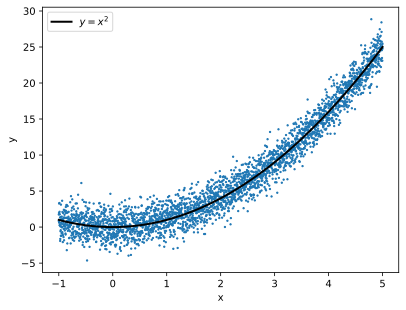

In [29]:
%config InlineBackend.figure_format = "svg"
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

N = 3000
X = np.linspace(-1, 5, N)
Y = X ** 2 + 0.5 * np.random.normal(size=N, scale=3)

plt.scatter(X, Y, s=2, marker="o")
plt.plot(X, X ** 2, color="black", linewidth=2, label="$y = x^2$")
plt.xlabel("x")
plt.ylabel("y")
plt.legend();

For fun, we drop `X` as hidden variable and create a time-series dataset based on lag features for `Y`. 

In [30]:
def create_lag_dataset(Y, valid_frac=0.15, window=10):
    """
    Create a supervised dataset where inputs are lagged values of Y.
    The last `valid_frac` fraction of the series is used for validation.
    """
    Y_lags = np.lib.stride_tricks.sliding_window_view(Y, window_shape=window+1)
    X_all = Y_lags[:, :-1]  # previous 'window' values
    y_all = Y_lags[:, -1]   # next value
    
    split_point = int(len(X_all) * (1 - valid_frac))
    
    X_train = X_all[:split_point]
    y_train = y_all[:split_point]
    X_valid = X_all[split_point:]
    y_valid = y_all[split_point:]
    
    return X_train, y_train, X_valid, y_valid


# only use observed target signal
X_train, y_train, X_valid, y_valid = create_lag_dataset(Y, valid_frac=0.15, window=10)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

(2541, 10) (2541,)
(449, 10) (449,)


### Model

**NOTE:** `Linear` adjusts the distribution of the [initial weights](https://en.wikipedia.org/wiki/Weight_initialization#Glorot_initialization) so that the activations do not diverge. The parameter `alpha` balances between choice of ReLU or Tanh activation. **Xavier** and **He initialization** is discussed further in a future notebook.

In [31]:
class Linear:
    def __init__(self, input_size, output_size):
        alpha = 0.5  # 0: Xavier (tanh), 1: He (relu)
        fan_in, fan_out = input_size, output_size
        var = 2 / ((1 - alpha) * (fan_in + fan_out) + alpha * fan_in)
        w = np.random.randn(fan_in, fan_out) * np.sqrt(var)
        b = np.zeros((1, output_size))
        self.W = Tensor(w, requires_grad=True)
        self.B = Tensor(b, requires_grad=True)

    def forward(self, x):
        return x @ self.W + self.B
    
    def __call__(self, x):
        return self.forward(x)
    

class Tanh:
    def __init__(self):
        pass
    
    def forward(self, x):
        return x.tanh()
    
    def __call__(self, x):
        return self.forward(x)
    

class ReLU:
    def __init__(self):
        pass
    
    def forward(self, x):
        return x.relu()
    
    def __call__(self, x):
        return self.forward(x)


class Sequential:
    def __init__(self, *layers):
        self.layers = layers
        self.params = OrderedDict()
        for i, layer in enumerate(layers):
            if isinstance(layer, Linear):
                self.params[f"W{i+1}"] = layer.W
                self.params[f"B{i+1}"] = layer.B

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def __call__(self, x):
        return self.forward(x)
    
    def __getitem__(self, i: int):
        return self.layers[i]
    
    def parameters(self):
        return self.params.values()


model_fn = lambda Act: Sequential(
    Linear(input_size=10, output_size=64), Act(),
    Linear(input_size=64, output_size=64), Act(),
    Linear(input_size=64, output_size=1)
)

Sample input:

In [32]:
x = Tensor(X_train[:4])
model = model_fn(ReLU)
model(x)

Tensor(data=[[2.13385223]
 [0.91173492]
 [1.41372528]
 [1.95070759]], requires_grad=True)

Indexing the layers:

In [33]:
model[0].W.shape, model[0].B.shape

((10, 64), (1, 64))

### Training loop

In [34]:
import random
random.seed(RANDOM_SEED)

class DataLoader:
    def __init__(self, X, Y, batch_size):
        """Get last value of each sequence as label."""
        self.batch_size = batch_size
        self.dataset = list(zip(X, Y))
    
    def load(self):
        """Sample a random batch from the dataset."""
        batch = random.sample(self.dataset, self.batch_size)
        x, y = zip(*batch)
        x, y = np.stack(x), np.stack(y)
        x = Tensor(x, requires_grad=False)
        y = Tensor(y.reshape(-1, 1), requires_grad=False)
        return x, y

    def __len__(self):
        return len(self.dataset)

Sample input-output pair:

In [35]:
batch = DataLoader(X_train, y_train, batch_size=32).load()
x, y = batch
x.shape, y.shape

((32, 10), (32, 1))

MEAN, POW, and SUB allows us to implement MSE loss. Interestingly, we are also able to cleanly implement [L2 regularization](https://developers.google.com/machine-learning/crash-course/overfitting/regularization) (e.g. with `float * Tensor` as valid OP). Hence, the loss is given by 

$$\mathcal{L} = \frac{1}{B} \sum_b (\hat{y}_b - y_b)^2 + \alpha \sum_{\ell} \sum_j ({\Theta^\ell_j})^2$$

where $\ell$ is the layer index.

In [ ]:
def mse_loss(out: Tensorable, y: Tensorable):
    return ((out - y) ** 2).mean()

def weight_reg(model, alpha=0.1):
    s = 0.0
    for w in model.parameters():
        s += (w ** 2).sum()
    return alpha * s

def sgd_step(model, lr=1.0):
    for p in model.parameters():
        p.data -= lr * p.grad
        p.grad = None           # reset grads


# sanity check (mse loss)
w = model[0].W
assert w.grad is None
loss = mse_loss(model(x), y)
loss.backward()
assert w.grad is not None

print(f"‖w‖ before step: {np.linalg.norm(w.data):.4f}")
sgd_step(model, lr=0.01)
print(f"‖w‖ after  step: {np.linalg.norm(w.data):.4f}")

‖w‖ before step: 5.7630
‖w‖ after  step: 5.8034


In [37]:
# sanity check (L2 regularization)
w = model[0].W
assert w.grad is None
loss = weight_reg(model, alpha=1.0)
loss.backward()
assert w.grad is not None

print(f"‖w‖ before step: {np.linalg.norm(w.data):.4f}")
sgd_step(model, lr=0.01)
print(f"‖w‖ after  step: {np.linalg.norm(w.data):.4f}")

‖w‖ before step: 5.8034
‖w‖ after  step: 5.6873


We're ready to train our model!

In [38]:
from tqdm.notebook import tqdm

model = model_fn(Tanh)
num_steps = 10000
lr = 0.0001
hist = []
train_loader = DataLoader(X_train, y_train, 16)
for _ in tqdm(range(num_steps)):
    x, y = train_loader.load()
    loss = mse_loss(model(x), y)
    loss.backward()
    sgd_step(model, lr=lr)     # no need to zero grad
    hist.append(loss.data)

  0%|          | 0/10000 [00:00<?, ?it/s]

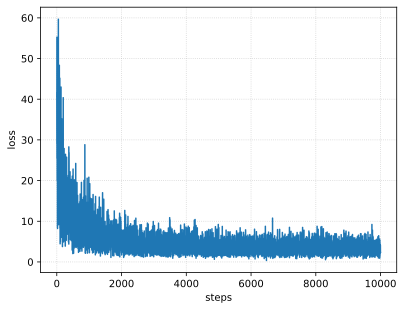

In [39]:
#| code-fold: true
plt.plot(hist)
plt.ylabel("loss")
plt.xlabel("steps")
plt.grid(alpha=0.6, linestyle="dotted");

**Trained model.** Note validation set does not chain together preds, i.e. validation lagged features are also GT. The trained model sucks but it's an MLP on time-series data, so it is somewhat expected that the performance will not be great.

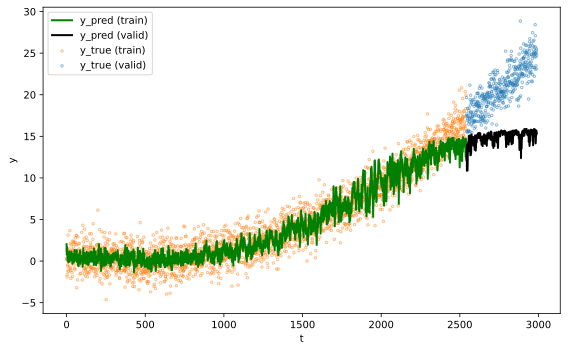

In [40]:
#| code-fold: true
y_train_pred = model(Tensor(X_train)).data.reshape(-1)
y_valid_pred = model(Tensor(X_valid)).data.reshape(-1)
t_train = np.arange(len(y_train))
t_valid = np.arange(len(y_train), len(y_train) + len(y_valid))

plt.figure(figsize=(8, 5))
plt.plot(t_train, y_train_pred, linewidth=2, label="y_pred (train)", color="green")
plt.plot(t_valid, y_valid_pred, linewidth=2, label="y_pred (valid)", color="black")
plt.scatter(t_train, y_train, label="y_true (train)", alpha=0.5, marker="o", s=6, facecolors="none", edgecolors="C1")
plt.scatter(t_valid, y_valid, label="y_true (valid)", alpha=0.5, marker="o", s=6, facecolors="none", edgecolors="C0")

plt.xlabel("t")
plt.ylabel("y")
plt.legend()
plt.tight_layout()
plt.show();

$\blacksquare$